In [1]:
#import os
#print(os.environ['PIP_DEFAULT_TIMEOUT'])
## export PIP_DEFAULT_TIMEOUT=100

In [1]:
from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from numba import complex128,float64,int64,jit
import matplotlib.pyplot as plt
import numpy as np
import quadpy

#custom module
from fieldplot import GetFlow3D
from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D
from scattnlay import fieldnlay
from scattnlay import scattnlay

import nanoscale_test
import scattnlay

%run kostin_kod.py

In [2]:
import sphereml

In [3]:
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py

In [9]:
def evaluate_old(ind, layers=2, quad_n=31):
    assert len(ind)==layers*3+1
    
    r = ind[-1]
    x = ind[:layers]
    m_ = ind[layers:3*layers][::2]
    m_j = ind[layers:3*layers][1::2]
    m = map(lambda t: t[0]+t[1]*1j, zip(m_, m_j))
    
    m = [z for _,z in sorted(zip(x,m), key=lambda pair: pair[0])]
    x = sorted(x)
    
    m = np.array(m)
    x = np.array(x)
    
    #print("trying {}".format(ind))
    #print("trying {} {} {}".format(x, m, r))
    
    coords = get_points('quad', r=r, quad_n=quad_n)
    Iprj = integrand(coords, x, m)
    Ptot = quadpy.sphere.integrate(lambda coords: integrand(coords, x, m),
                            [0.0, 0.0, 0.0], r,
                            quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
    #print("success")
    
    return 3./4.*np.max(Iprj)/Ptot

In [4]:
def evaluate(ind, layers=2):
    assert len(ind)==layers*3+1
    
    r = ind[-1]
    x = ind[:layers]
    m_ = ind[layers:3*layers][::2]
    m_j = ind[layers:3*layers][1::2]
    m = map(lambda t: t[0]+t[1]*1j, zip(m_, m_j))
    
    m = [z for _,z in sorted(zip(x,m), key=lambda pair: pair[0])]
    x = sorted(x)
    
    m = np.array(m)
    x = np.array(x)
    
    px = 1.
    py = 0.
    pz = 0.

    wl = 0.455
    NL = layers
    RL = np.zeros(NL)
    eL = np.zeros(NL+1, dtype=complex)
    eL[:NL] = m[:]
    eL[NL] = 1.
    RL[:] = x[:] / 1000.0
    Rd = r / 1000.0
    
    res = sphereml.evaluate_directivity(RL, eL, Rd, wl, px, py, pz, np.pi, 0.)
    if np.isnan(res): 
        print("!!! ERROR {}".format(ind))
        print(" eL:{}".format(eL))
        print(" RL:{}".format(RL))
        print("  x:{}".format(x))
    
    return res

In [5]:
def run_evaluation(algo, n_it, r_limits, m_limits, mj_limits, layers, evaluate=evaluate):
    def helper(ind):
        helper.calls += 1
        return evaluate(ind, layers=layers)
    helper.calls = 0
    
    hist = []
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=5*len(limits), limits=limits)
        for i in range(n_it/5/len(limits)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, evaluate(xk, layers)))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=5*len(limits), maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=20, generations=1000000, log=False, 
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    else:
        raise AssertionError("Unknown algo")
        
    print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

In [6]:
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}

In [7]:
def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

1+1: best 7.74208649841 for ind [112.19194147379828, 10, 0, 72.41501304233358]
genetic: best 7.88002034955 for ind [92.50463425355932, 5.46294974722862, 0, 99.23341877850032]
JADE: best 8.73982595337 for ind [113.99538795   8.68703908   0.          92.97021011]
DE: best 9.34371126401 for ind [69.47583309  7.27106324  0.         75.00103963]
CPU times: user 6.92 s, sys: 45.3 ms, total: 6.97 s
Wall time: 7.14 s


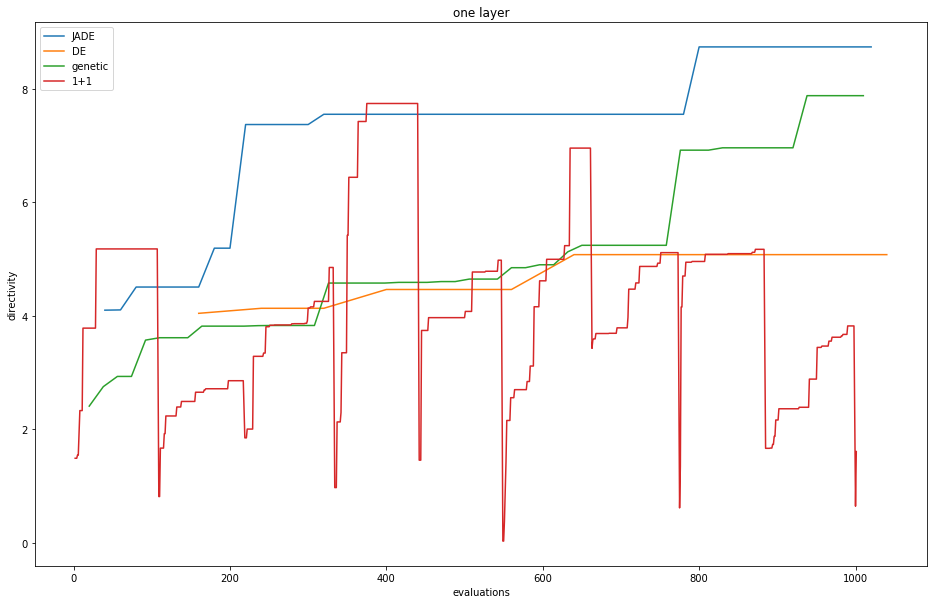

In [8]:
%%time
n_it=1000
_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=1, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=1, **limitsdict)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=1, **limitsdict)
_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=1, **limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("one layer")
plot_hist(jade_hist, "JADE")
plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
plot_hist(opo_hist, "1+1")
plt.legend();

1+1: best 10.4205445208 for ind [108.74923442680839, 109.1157767892031, 10, 0.003996108275285695, 5.482656874829437, 0.31893036732912966, 53.33809334116136]
genetic: best 12.1975822246 for ind [108.19600366965261, 25.96982988742585, 6.246920589194365, 0.0009479064213124708, 10, 0.4, 103.17326290339606]
JADE: best 12.1243544888 for ind [9.70484657e+01 4.17659702e+01 7.01112089e+00 0.00000000e+00
 3.06177801e+00 2.31174022e-02 1.11847594e+02]
DE: best 9.02960100459 for ind [3.13315916e+01 7.07098228e+01 1.00000000e+01 4.49301696e-02
 5.78325871e+00 6.68236297e-03 9.28501547e+01]
CPU times: user 21min 24s, sys: 1.56 s, total: 21min 25s
Wall time: 21min 25s


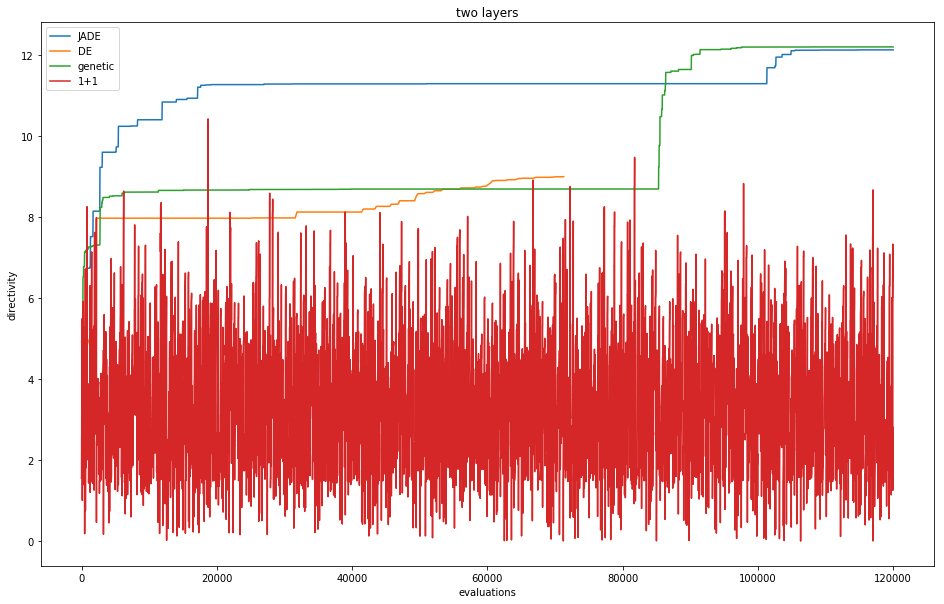

In [9]:
%%time
n_it=120000
_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=2, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=2, **limitsdict)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=2, **limitsdict)
_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=2, **limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("two layers")
plot_hist(jade_hist, "JADE")
plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
plot_hist(opo_hist, "1+1")
plt.legend();

In [ ]:
%%time
results = []
n_it=200000
for l in [2,3,4,5,8,16]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5,8,16 layers")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

JADE: best 12.8978866366 for ind [7.69669167e+01 2.48294172e+01 7.68466347e+00 1.47816518e-03
 3.83192573e+00 0.00000000e+00 6.48520495e+01]
JADE: best 18.16861301 for ind [1.12042449e+02 3.01478111e+01 4.34982954e+01 6.03116823e+00
 3.07570323e-04 1.00000000e+01 3.27806390e-01 3.00000000e+00
 7.84191444e-02 1.25192178e+02]
JADE: best 16.0748355235 for ind [1.16759701e+02 1.78940863e+01 1.55703304e+01 1.20000000e+02
 9.97130211e+00 0.00000000e+00 4.57058169e+00 0.00000000e+00
 4.42498377e+00 2.94455935e-01 7.40854439e+00 1.96116103e-02
 1.00751265e+02]


JADE: best 8.07689632946 for ind [9.51929000e+01 2.47532498e+01 4.34476212e+00 3.91523222e-03
 8.60495244e+00 2.32666489e-01 1.37883027e+02]
JADE: best 12.0729557639 for ind [1.58994635e+01 1.09089694e+02 1.00000000e+01 5.56636783e+00
 1.75065140e-01 1.00000000e+01 0.00000000e+00 4.30862134e+00
 6.47131864e-02 1.07340096e+02]
JADE: best 7.13895450977 for ind [3.26851622e+01 1.16617442e+02 2.31171186e+01 2.78327937e+01
 8.55563343e+00 3.70847812e-01 3.57149737e+00 0.00000000e+00
 5.51792778e+00 2.87388447e-01 7.21874651e+00 8.30570438e-02
 1.40027426e+02]
JADE: best 9.08162435485 for ind [3.03524802e+01 5.73096821e+01 1.20000000e+02 1.00000000e+01
 5.18062915e+01 3.76908884e+00 1.98308894e-01 7.70535759e+00
 3.31306495e-03 5.04117019e+00 0.00000000e+00 4.28938671e+00
 0.00000000e+00 1.00000000e+01 2.14342611e-03 1.17864970e+02]
JADE: best 7.13583560809 for ind [1.12024796e+02 8.73100278e+01 1.13092047e+02 1.00000000e+01
 5.65900299e+01 1.00000000e+01 1.00000000e+01 5.85883946e+01
 3.531

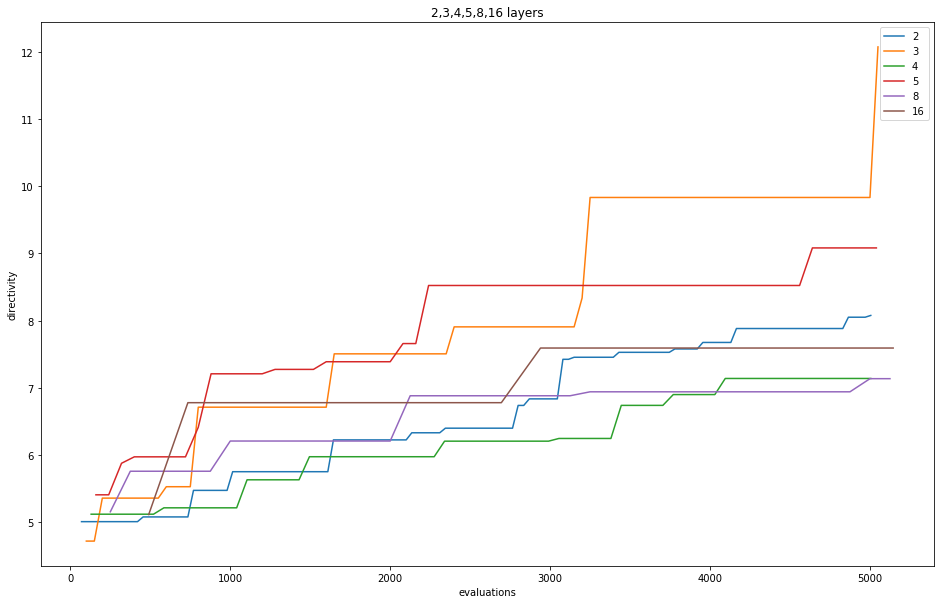

In [11]:
%%time
results = []
n_it=5000
for l in [2,3,4,5,8,16]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5,8,16 layers")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

JADE: best 12.1784495428 for ind [ 10.         117.65985265  10.           6.7820957    0.39048981
   7.96562299   0.           3.53725599   0.         112.98878168]
JADE: best 11.7579371646 for ind [1.01077288e+02 1.20000000e+02 3.71929775e+01 8.55080224e+01
 9.80357939e+00 0.00000000e+00 7.62601718e+00 0.00000000e+00
 8.35677460e+00 7.58042183e-02 3.00000000e+00 2.80982237e-02
 1.38576071e+02]
CPU times: user 1min 44s, sys: 184 ms, total: 1min 44s
Wall time: 1min 44s


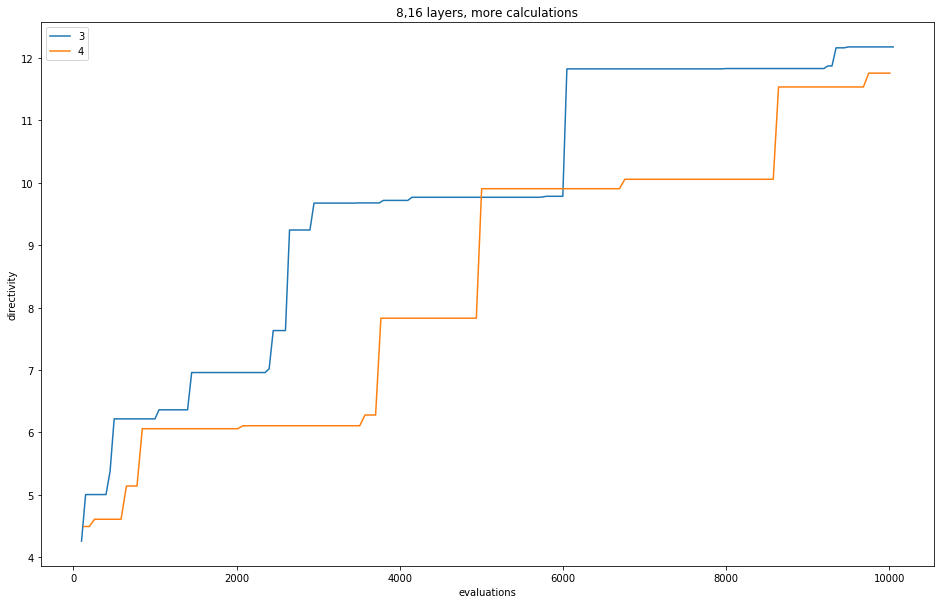

In [13]:
%%time
results = []
n_it=10000
for l in [3,4]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("3,4 layers, more calculations")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

JADE: best 8.79812535366 for ind [120.          54.58796465  22.32331975   7.18693981   0.
  10.           0.           7.26308414   0.         124.87072194]
JADE: best 10.3509513727 for ind [ 10.03628889 120.          64.10726909 120.          72.22027
  95.5394389   60.17923631  10.           3.92709235   0.
   8.82275309   0.           9.5021522    0.          10.
   0.           7.23772691   0.           4.0980726    0.
   9.99695246   0.           9.85567696   0.         110.32847759]
JADE: best 13.1530893401 for ind [2.40000000e+02 1.00000000e+01 1.00000000e+01 2.82515446e+01
 0.00000000e+00 9.07730794e+00 3.39516140e-01 9.28509436e+00
 4.60925595e-02 1.43563123e+02]
JADE: best 11.07788994 for ind [2.40000000e+02 5.27896321e+01 1.59851654e+02 6.72302756e+01
 1.20184461e+02 1.00000000e+01 2.30827134e+02 6.96258135e+01
 3.00000000e+01 1.43421820e-01 1.49867034e+01 3.34256822e-01
 1.82051611e+01 0.00000000e+00 1.54343638e+01 7.24402816e-02
 3.00000000e+00 0.00000000e+00 3.00000000e+

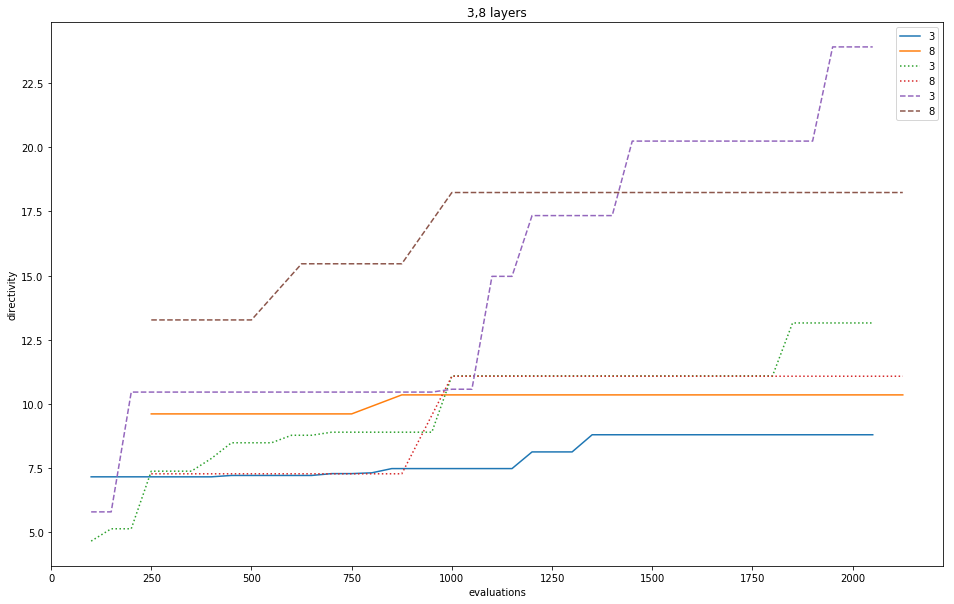

In [14]:
%%time
limitsdicts = [
    ({'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.0)}, '-'),
    ({'r_limits':(10,240), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}, ':'),
    ({'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}, '--')
]

results = []
n_it=2000
for ld,linestyle in limitsdicts:
    for l in [3,8]:
        _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **ld)
        results.append((hist, str(l), linestyle))

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("3,8 layers")
for hist,label,linestyle in results:
    plot_hist(hist, label, linestyle)
plt.legend();

JADE: best 29.9492751683 for ind [438.24846985  51.33710871   6.59566136   0.          22.0574285
   0.         249.46111228]
JADE: best 116.767186115 for ind [1.63099880e+01 3.60844033e+01 4.79969369e+02 1.73626019e+01
 1.28749510e-01 3.92898362e+00 5.75766328e-04 2.99747159e+01
 0.00000000e+00 4.64518151e+02]
JADE: best 179.325103749 for ind [1.00000000e+01 3.50912487e+02 1.00000000e+01 4.80000000e+02
 1.92760711e+01 4.00000000e-01 2.84770389e+01 0.00000000e+00
 3.00000000e+00 8.91234902e-02 1.38095594e+01 0.00000000e+00
 4.24605132e+02]
JADE: best 103.451030536 for ind [4.80000000e+02 1.86007177e+02 4.80000000e+02 1.34223372e+01
 2.70606948e+01 1.94638094e+01 0.00000000e+00 2.63703452e+01
 0.00000000e+00 2.78994644e+01 1.45241240e-01 3.00000000e+00
 2.83792253e-01 3.43420911e+00 1.99470466e-01 4.64159542e+02]
CPU times: user 3min 17s, sys: 300 ms, total: 3min 17s
Wall time: 3min 17s


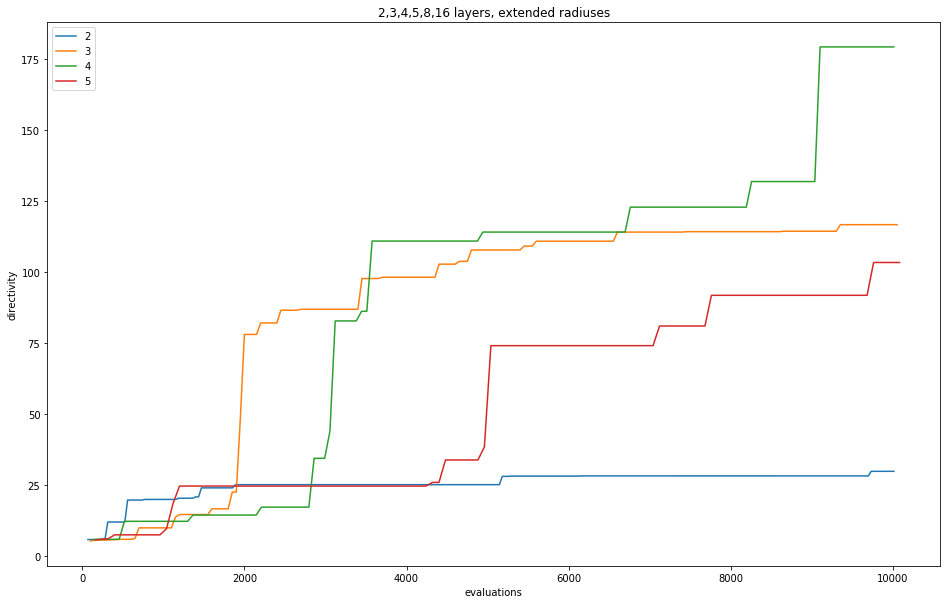

In [15]:
%%time
ld={'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}
results = []
n_it=10000
for l in [2,3,4,5]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **ld)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5,8,16 layers, extended radiuses")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

genetic: best 150.423594279 for ind [62.46505653110342, 474.10034635895624, 56.7011880016211, 6.237992691185768, 0.16175825274601457, 28.637846656504937, 0, 23.827016639536673, 0.004048956318531306, 341.9804097167524]
JADE: best 125.911220715 for ind [4.79428834e+02 3.09046641e+01 4.96120464e+01 2.99300640e+01
 0.00000000e+00 3.00000000e+00 1.93241943e-01 4.54899853e+00
 0.00000000e+00 4.75969628e+02]
CPU times: user 2min 45s, sys: 232 ms, total: 2min 45s
Wall time: 2min 45s


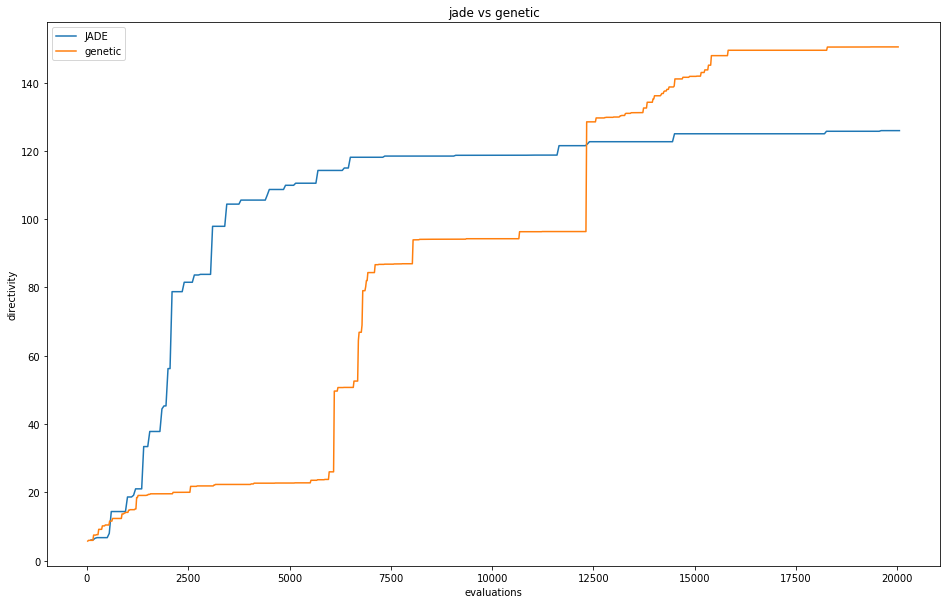

In [16]:
%%time
n_it=20000
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=3, **ld)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=3, **ld)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs genetic, 3 layers")
plot_hist(jade_hist, "JADE")
plot_hist(gen_hist, "genetic")
plt.legend();

genetic: best 132.374050444 for ind [10, 446.1454525423972, 259.95884469030267, 10, 3, 0, 20.87760021713425, 0, 28.94073682178405, 0, 3.1875632436008563, 0, 410.8542331616047]
JADE: best 160.20261336 for ind [4.79307001e+02 6.50352233e+01 2.54563851e+01 3.45737405e+02
 2.23421442e+01 0.00000000e+00 5.20751814e+00 1.07655545e-01
 6.85057575e+00 0.00000000e+00 3.00000000e+01 0.00000000e+00
 4.40191821e+02]
CPU times: user 8min 34s, sys: 808 ms, total: 8min 34s
Wall time: 8min 34s


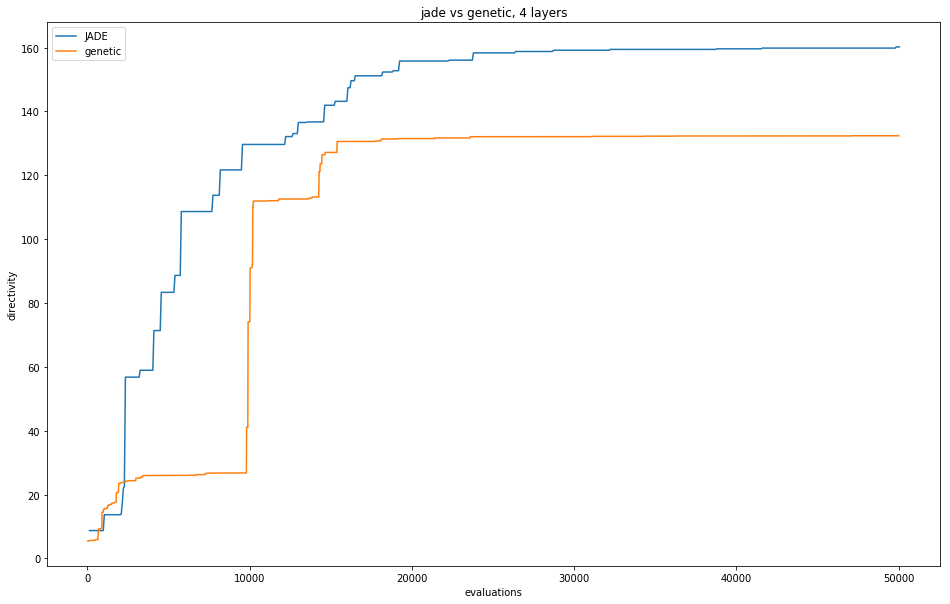

In [17]:
%%time
n_it=50000
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=4, **ld)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=4, **ld)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs genetic, 4 layers")
plot_hist(jade_hist, "JADE")
plot_hist(gen_hist, "genetic")
plt.legend();

In [ ]:
def fitness(p):
    x, y = p[0], p[1]
    val = 20 + (x**2 - 10*cos(2*pi*x)) + (y**2 - 10*cos(2*pi*y))
    return -val

results = []
for l in [1,2,4,8,16,5,7,9]:
    _, _, hist = run_evaluation('JADE', n_it=2500, r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), 
                                layers=l)
    results.append((hist, str(l)))